In [79]:
from pprint import pprint
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import torch

In [80]:
class TextDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_len=512):
        self.dataframe = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.dataframe.iloc[idx, 0]
        label = 0 if self.dataframe.iloc[idx, 1] == 'ちいかわ' else 1
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids = inputs['input_ids'].flatten()
        attention_mask = inputs['attention_mask'].flatten()
        return input_ids, attention_mask, label

In [81]:
class ClassifierModel(torch.nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()
        self.bert = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
        self.linear = torch.nn.Linear(768, 2)  # BERTの隠れ層の次元数と出力クラス数

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs[0]
        pooled_output = last_hidden_state[:, 0]
        return self.linear(pooled_output)

In [82]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
pprint(f'device: {device}')

'device: cuda'


In [83]:
def to_device(device, *args):
    return [x.to(device) for x in args]

In [84]:
tokenizer = BertTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
train_dataset = TextDataset('data/train.csv', tokenizer, 30)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TextDataset('data/test.csv', tokenizer, 30)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\hiroga\miniconda3\envs\chiikawa-yonezu\Lib\site-packages\transformers\tokenization_utils_base.py:2618: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


('labels: tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, '
 '0, 0, 0, 0,\n'
 "        0, 1, 1, 1, 1, 1, 0, 0], device='cuda:0'), outputs: tensor([[ "
 '0.0429,  0.2418],\n'
 '        [-0.0044, -0.0984],\n'
 '        [ 0.0964, -0.2777],\n'
 '        [ 0.1607, -0.1132],\n'
 '        [-0.2043, -0.0407],\n'
 '        [-0.0395,  0.3410],\n'
 '        [ 0.1579,  0.0840],\n'
 '        [ 0.0384, -0.0177],\n'
 '        [ 0.0071,  0.0044],\n'
 '        [-0.0592, -0.1915],\n'
 '        [ 0.1861,  0.0956],\n'
 '        [-0.1312, -0.2826],\n'
 '        [ 0.0298, -0.0592],\n'
 '        [ 0.1236,  0.0048],\n'
 '        [-0.1041, -0.2564],\n'
 '        [ 0.0635, -0.1289],\n'
 '        [ 0.0263,  0.1378],\n'
 '        [-0.1583, -0.0943],\n'
 '        [-0.2062, -0.1103],\n'
 '        [ 0.0584,  0.0412],\n'
 '        [-0.1842,  0.1659],\n'
 '        [ 0.0949,  0.0177],\n'
 '        [ 0.1867,  0.0272],\n'
 '        [-0.0521,  0.0419],\n'
 '        [ 0.1391, -0.0235],\n'
 '        [-0.

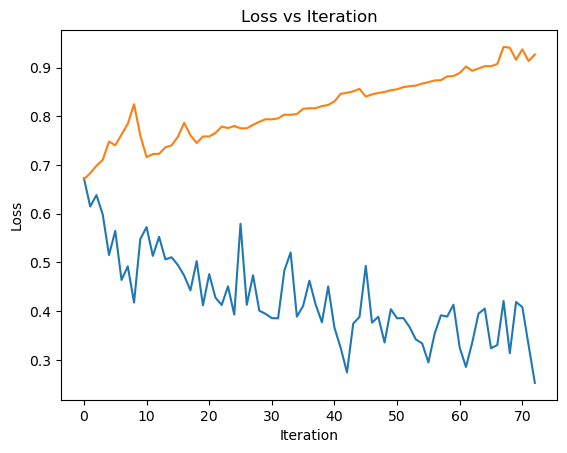

In [85]:
epoch = 1
net: torch.nn.Module = ClassifierModel().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

train_loss_values = []  # List to store loss values
test_loss_values = []  # List to store loss values

for e in range(epoch):
    for input_ids, attention_mask, labels in train_loader:
        """Training loop"""
        net.train()
        input_ids, attention_mask, labels = to_device(device, input_ids, attention_mask, labels)
        optimizer.zero_grad()
        outputs = net(input_ids, attention_mask)
        pprint(f"labels: {labels}, outputs: {outputs}")
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        pprint(f'train_loss: {loss.item()}')
        train_loss_values.append(loss.item())  # Append loss value to the list

        """Validation loop"""
        net.eval()
        test_loss = 0.0
        num_batches = 0
        with torch.no_grad():
            for test_input_ids, test_attention_mask, test_labels in test_loader:
                test_input_ids, test_attention_mask, test_labels = to_device(device, test_input_ids, test_attention_mask, test_labels)
                test_outputs = net(test_input_ids, test_attention_mask)
                pprint(f"test_labels: {test_labels}, test_outputs: {test_outputs}")

                test_inputs_decoded = [tokenizer.decode(x) for x in test_input_ids]
                test_labels_nihongo = ['米津玄師' if x == 1 else 'ちいかわ' for x in test_labels]
                test_outputs_nihongo = ['米津玄師' if x[0] > x[1] else 'ちいかわ' for x in test_outputs]
                # pprint(list(zip(test_inputs_decoded, test_labels_nihongo, test_outputs_nihongo)))

                batch_test_loss = torch.nn.functional.cross_entropy(test_outputs, test_labels)
                test_loss += batch_test_loss.item()
                num_batches += 1

        avg_test_loss = test_loss / num_batches
        pprint(f'test_loss: {avg_test_loss}')
        test_loss_values.append(avg_test_loss)

# Plot the loss values
plt.plot(train_loss_values, label='Training loss')
plt.plot(test_loss_values, label='Validation loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs Iteration')
plt.show()
